## K-means Clustering in Python using OpenAI

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Get_embeddings_from_dataset Notebook](Get_embeddings_from_dataset.ipynb).

In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval

datafile_path = "./data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [2]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


Cluster
0    4.149351
3    4.179894
2    4.195489
1    4.407407
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

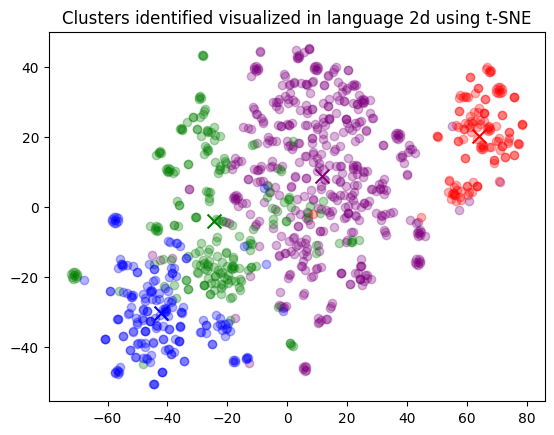

In [3]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [7]:
from openai import OpenAI
client = OpenAI()

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response.choices[0].text.replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  Positive reviews about food products.
4, Yummy!!!:   This product is the closest I've come to finding the pumpkin spice lat
4, YUMMMM!:   Am a peanut butter junkie, but hate the calories.  This item is great.
5, Tasty!:   I purchased this to send to my son who's away at college. It was deliv
4, good deal:   it's okay, but I would prefer a larger nugget type product. This ends 
5, yummy:   the best matza balls out there- super yummy with salt. too bad they gu
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  Positive reviews about products and their effectiveness.
5, Hidden Springs Maple syrup:   This is one of the very finest maple syrups I have ordered and enjoyed
4, girls bettlejuice costume:   Fit perfectly. Size is true. Expected exactly what was described onlin
5, Vinegar Is Magic!:   I have always heard about vinegar being great for cleaning, I'm sure I
5, A God Sent Remedy!!!:   I love this st

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.